In [9]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo

from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [10]:
import os

# Fonte: https://www.kaggle.com/datasets/kelvinobiri/credit-card-transactions

data_path = 'credit_card_transactions.csv'
url = 'https://raw.githubusercontent.com/rogerioferreira/MVP-Machine_Learnin-PUC-RIO/refs/heads/main/dados/credit_card_transactions.csv'

if os.path.exists(data_path):
    # caraga do dataset localmente, caso exista
    df = pd.read_csv(data_path)
else:
    # caraga do dataset pelo Git Hub
    df = pd.read_csv(url)


# remoção de features não relevantes para o treinamento
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)

In [11]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,8,CASH_OUT,158007.12,0.00,0.00,474016.32,1618631.97,0
1,236,CASH_OUT,457948.30,0.00,0.00,2720411.37,3178359.67,0
2,37,CASH_IN,153602.99,11160428.67,11314031.67,3274930.56,3121327.56,0
3,331,CASH_OUT,49555.14,10865.00,0.00,0.00,49555.14,0
4,250,CASH_OUT,29648.02,0.00,0.00,56933.09,86581.10,0


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Instanciando o Encoder (OneHot, Ordinal)
encoder = OrdinalEncoder()
encoded_features = encoder.fit_transform(df[['type']])
encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['type']))

df.drop(columns=['type'], inplace=True)
df = pd.concat([encoded_data, df], axis=1)

# Instanciando o StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])
scaled_data = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']))

df.drop(columns=['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], inplace=True) # exclusão das colunas não normalizadas
df= pd.concat([scaled_data, df], axis=1)

In [13]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type,isFraud
0,-1.659306,-0.035545,-0.288462,-0.292161,-0.187603,0.110208,1.0,0
1,-0.051409,0.443941,-0.288462,-0.292161,0.492531,0.540219,1.0,0
2,-1.454793,-0.042586,3.583585,3.586034,0.660422,0.524496,0.0,0
3,0.618548,-0.208917,-0.284692,-0.292161,-0.331119,-0.322380,1.0,0
4,0.047321,-0.240741,-0.288462,-0.292161,-0.313882,-0.312172,1.0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            199999 non-null  float64
 1   amount          199999 non-null  float64
 2   oldbalanceOrg   199999 non-null  float64
 3   newbalanceOrig  199999 non-null  float64
 4   oldbalanceDest  199999 non-null  float64
 5   newbalanceDest  199999 non-null  float64
 6   type            199999 non-null  float64
 7   isFraud         199999 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 12.2 MB


In [15]:
# Preparação dos dados

# Separação em bases de treino e teste (holdout)
array = df.values
X = array[:,0:6] # atributos
y = array[:,6] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão

# Criando os folds para a validação cruzada
num_particoes = 5 # número de folds da validação cruzada (3, 5, 10)
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em N folds

KNN: 0.8993 (0.0011)
CART: 0.9060 (0.0006)
NB: 0.8371 (0.0039)
ADC: 0.8666 (0.0202)
RFC: 0.9396 (0.0009)
ETC: 0.9374 (0.0005)


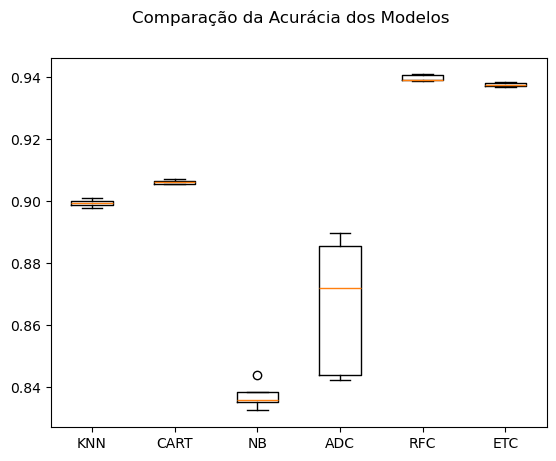

In [16]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(7) 

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC())) # modelo suspenso em virtude do tempo de processamento
models.append(('ADC', AdaBoostClassifier()))
models.append(('RFC', RandomForestClassifier())) 
models.append(('ETC', ExtraTreesClassifier()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = f'{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})' # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure() 
fig.suptitle('Comparação da Acurácia dos Modelos') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()